In [2]:
from theano.sandbox import cuda

In [3]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [77]:
#path = "data/ml-20m/"
path = "./data/movielens/sample/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [78]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [68]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [79]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [80]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [81]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [82]:

ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205


In [11]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [12]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [13]:
n_factors = 50

In [14]:
np.random.seed = 42

Randomly split into training and validation.

In [15]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [16]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [17]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [18]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [19]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [20]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [21]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [22]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79861 samples, validate on 20143 samples
Epoch 1/1
79861/79861 [==============================] - 5s - loss: 9.9012 - val_loss: 4.2934


In [24]:
model.optimizer.lr=0.01

In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79861 samples, validate on 20143 samples
Epoch 1/3
79861/79861 [==============================] - 5s - loss: 3.1451 - val_loss: 2.8305
Epoch 2/3
79861/79861 [==============================] - 5s - loss: 2.4010 - val_loss: 2.6233
Epoch 3/3
79861/79861 [==============================] - 5s - loss: 2.2252 - val_loss: 2.5754


In [26]:
model.optimizer.lr=0.001

In [27]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79861 samples, validate on 20143 samples
Epoch 1/6
79861/79861 [==============================] - 5s - loss: 2.1573 - val_loss: 2.5671
Epoch 2/6
79861/79861 [==============================] - 5s - loss: 2.1205 - val_loss: 2.5727
Epoch 3/6
79861/79861 [==============================] - 5s - loss: 2.0945 - val_loss: 2.5755
Epoch 4/6
79861/79861 [==============================] - 5s - loss: 2.0739 - val_loss: 2.5858
Epoch 5/6
79861/79861 [==============================] - 5s - loss: 2.0542 - val_loss: 2.5927
Epoch 6/6
79861/79861 [==============================] - 5s - loss: 2.0350 - val_loss: 2.6026


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [28]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [29]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [30]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [31]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [32]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [33]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79861 samples, validate on 20143 samples
Epoch 1/1
79861/79861 [==============================] - 5s - loss: 8.9177 - val_loss: 3.5387


In [34]:
model.optimizer.lr=0.01

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79861 samples, validate on 20143 samples
Epoch 1/6
79861/79861 [==============================] - 5s - loss: 2.5960 - val_loss: 2.3110
Epoch 2/6
79861/79861 [==============================] - 5s - loss: 2.0008 - val_loss: 2.1158
Epoch 3/6
79861/79861 [==============================] - 5s - loss: 1.8399 - val_loss: 2.0203
Epoch 4/6
79861/79861 [==============================] - 5s - loss: 1.7417 - val_loss: 1.9547
Epoch 5/6
79861/79861 [==============================] - 5s - loss: 1.6621 - val_loss: 1.8817
Epoch 6/6
79861/79861 [==============================] - 5s - loss: 1.5868 - val_loss: 1.8163


In [36]:
model.optimizer.lr=0.001

In [37]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79861 samples, validate on 20143 samples
Epoch 1/10
79861/79861 [==============================] - 5s - loss: 1.5132 - val_loss: 1.7551
Epoch 2/10
79861/79861 [==============================] - 5s - loss: 1.4417 - val_loss: 1.6918
Epoch 3/10
79861/79861 [==============================] - 5s - loss: 1.3730 - val_loss: 1.6382
Epoch 4/10
79861/79861 [==============================] - 5s - loss: 1.3074 - val_loss: 1.5813
Epoch 5/10
79861/79861 [==============================] - 5s - loss: 1.2440 - val_loss: 1.5301
Epoch 6/10
79861/79861 [==============================] - 5s - loss: 1.1837 - val_loss: 1.4813
Epoch 7/10
79861/79861 [==============================] - 5s - loss: 1.1266 - val_loss: 1.4360
Epoch 8/10
79861/79861 [==============================] - 5s - loss: 1.0721 - val_loss: 1.3934
Epoch 9/10
79861/79861 [==============================] - 5s - loss: 1.0207 - val_loss: 1.3516
Epoch 10/10
79861/79861 [==============================] - 5s - loss: 0.9713 - val_loss: 1.3126

In [38]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79861 samples, validate on 20143 samples
Epoch 1/5
79861/79861 [==============================] - 5s - loss: 0.9256 - val_loss: 1.2774
Epoch 2/5
79861/79861 [==============================] - 5s - loss: 0.8823 - val_loss: 1.2450
Epoch 3/5
79861/79861 [==============================] - 5s - loss: 0.8418 - val_loss: 1.2137
Epoch 4/5
79861/79861 [==============================] - 5s - loss: 0.8041 - val_loss: 1.1886
Epoch 5/5
79861/79861 [==============================] - 5s - loss: 0.7696 - val_loss: 1.1634


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [39]:
model.save_weights(model_path+'bias.h5')

In [40]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [41]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.8786]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [42]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [43]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [44]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.54834563, 'Battlefield Earth (2000)'),
 (-0.12361625, 'Jaws 3-D (1983)'),
 (-0.072217733, 'Speed 2: Cruise Control (1997)'),
 (-0.040875994, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.026414901, 'Super Mario Bros. (1993)'),
 (0.003608068, 'Little Nicky (2000)'),
 (0.0036829575, 'Police Academy 6: City Under Siege (1989)'),
 (0.028731786, 'Wild Wild West (1999)'),
 (0.069617189, 'Blade: Trinity (2004)'),
 (0.081649184, 'Scary Movie 2 (2001)'),
 (0.084461115, 'Godzilla (1998)'),
 (0.10825212, 'Richie Rich (1994)'),
 (0.10861097, 'Anaconda (1997)'),
 (0.10907373, 'Batman & Robin (1997)'),
 (0.12603371, 'Spice World (1997)')]

In [45]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.3689268, 'Rush (2013)'),
 (1.3387703, 'Tom Jones (1963)'),
 (1.3274107, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.3239923, 'Shawshank Redemption, The (1994)'),
 (1.3189259, 'Blood Simple (1984)'),
 (1.3180107, 'Cyrano de Bergerac (1990)'),
 (1.3172115, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3084688, 'Letters from Iwo Jima (2006)'),
 (1.2936201, 'Harry Potter and the Half-Blood Prince (2009)'),
 (1.280498, 'Dallas Buyers Club (2013)'),
 (1.2736782, 'Town, The (2010)'),
 (1.2679926, 'Gold Rush, The (1925)'),
 (1.2588664, 'Argo (2012)'),
 (1.2557591, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2535061, 'Godfather, The (1972)')]

We can now do the same thing for the embeddings.

In [46]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [48]:
fac0 = movie_pca[0]

In [49]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.010019999, 'Gremlins 2: The New Batch (1990)'),
 (0.0091198944, 'Anaconda (1997)'),
 (0.0083910674, 'Daredevil (2003)'),
 (0.0082353009, 'Children of the Corn (1984)'),
 (0.0082325768, 'Police Academy 3: Back in Training (1986)'),
 (0.0079344846, "You Don't Mess with the Zohan (2008)"),
 (0.0068850666, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.006824445, 'Son in Law (1993)'),
 (0.0063183256, 'Stepford Wives, The (1975)'),
 (0.0056084325, 'Nutty Professor, The (1963)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.048984904, 'Usual Suspects, The (1995)'),
 (-0.048946463, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (-0.04810749, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (-0.047957331, 'Princess Bride, The (1987)'),
 (-0.047437139, 'Monty Python and the Holy Grail (1975)'),
 (-0.047245275, 'Run Lola Run (Lola rennt) (1998)'),
 (-0.046704359, 'American Beauty (1999)'),
 (-0.04629327, "Schindler's List (1993)"),
 (-0.045946505, 'Clerks (1994)'),
 (-0.045683019, 'Kill Bill: Vol. 1 (2003)')]

In [52]:
fac1 = movie_pca[1]

In [53]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [54]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.068775378, 'Annie Hall (1977)'),
 (0.06452959, 'Brokeback Mountain (2005)'),
 (0.063713901, 'City Lights (1931)'),
 (0.057772063, 'Manhattan (1979)'),
 (0.057561934, 'Clockwork Orange, A (1971)'),
 (0.054842819, 'Chinatown (1974)'),
 (0.054398447, 'Apocalypse Now (1979)'),
 (0.054071609, 'Wild Bunch, The (1969)'),
 (0.053248689, 'Bringing Up Baby (1938)'),
 (0.05292283, '2001: A Space Odyssey (1968)')]

In [55]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10182099, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.096300155, 'Armageddon (1998)'),
 (-0.085186951, 'Stargate (1994)'),
 (-0.075856388, 'Speed (1994)'),
 (-0.070268914, 'Titanic (1997)'),
 (-0.069502331, 'Outbreak (1995)'),
 (-0.067912973, 'Gone in 60 Seconds (2000)'),
 (-0.065968975, 'True Lies (1994)'),
 (-0.064969219, 'Jurassic Park (1993)'),
 (-0.064130388, 'Firm, The (1993)')]

In [56]:
fac2 = movie_pca[2]

In [57]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [58]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.084696867, 'Sabrina (1995)'),
 (0.07175529, "You've Got Mail (1998)"),
 (0.065283664, 'Sleepless in Seattle (1993)'),
 (0.06495782, 'Sound of Music, The (1965)'),
 (0.064666778, 'Christmas Story, A (1983)'),
 (0.063734375, 'While You Were Sleeping (1995)'),
 (0.063205421, 'Much Ado About Nothing (1993)'),
 (0.061586417, 'Double Jeopardy (1999)'),
 (0.060700685, 'Legally Blonde (2001)'),
 (0.057735831, 'Arsenic and Old Lace (1944)')]

In [59]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.11252716, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.10839814, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.089073293, 'Fight Club (1999)'),
 (-0.087804481, 'Silence of the Lambs, The (1991)'),
 (-0.080808811, 'Spaceballs (1987)'),
 (-0.080155924, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'),
 (-0.07674402, 'Clockwork Orange, A (1971)'),
 (-0.073928989, 'American Psycho (2000)'),
 (-0.072090141,
  'L\xc3\xa9on: The Professional (a.k.a. The Professional) (L\xc3\xa9on) (1994)'),
 (-0.069419809, 'American Beauty (1999)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [60]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

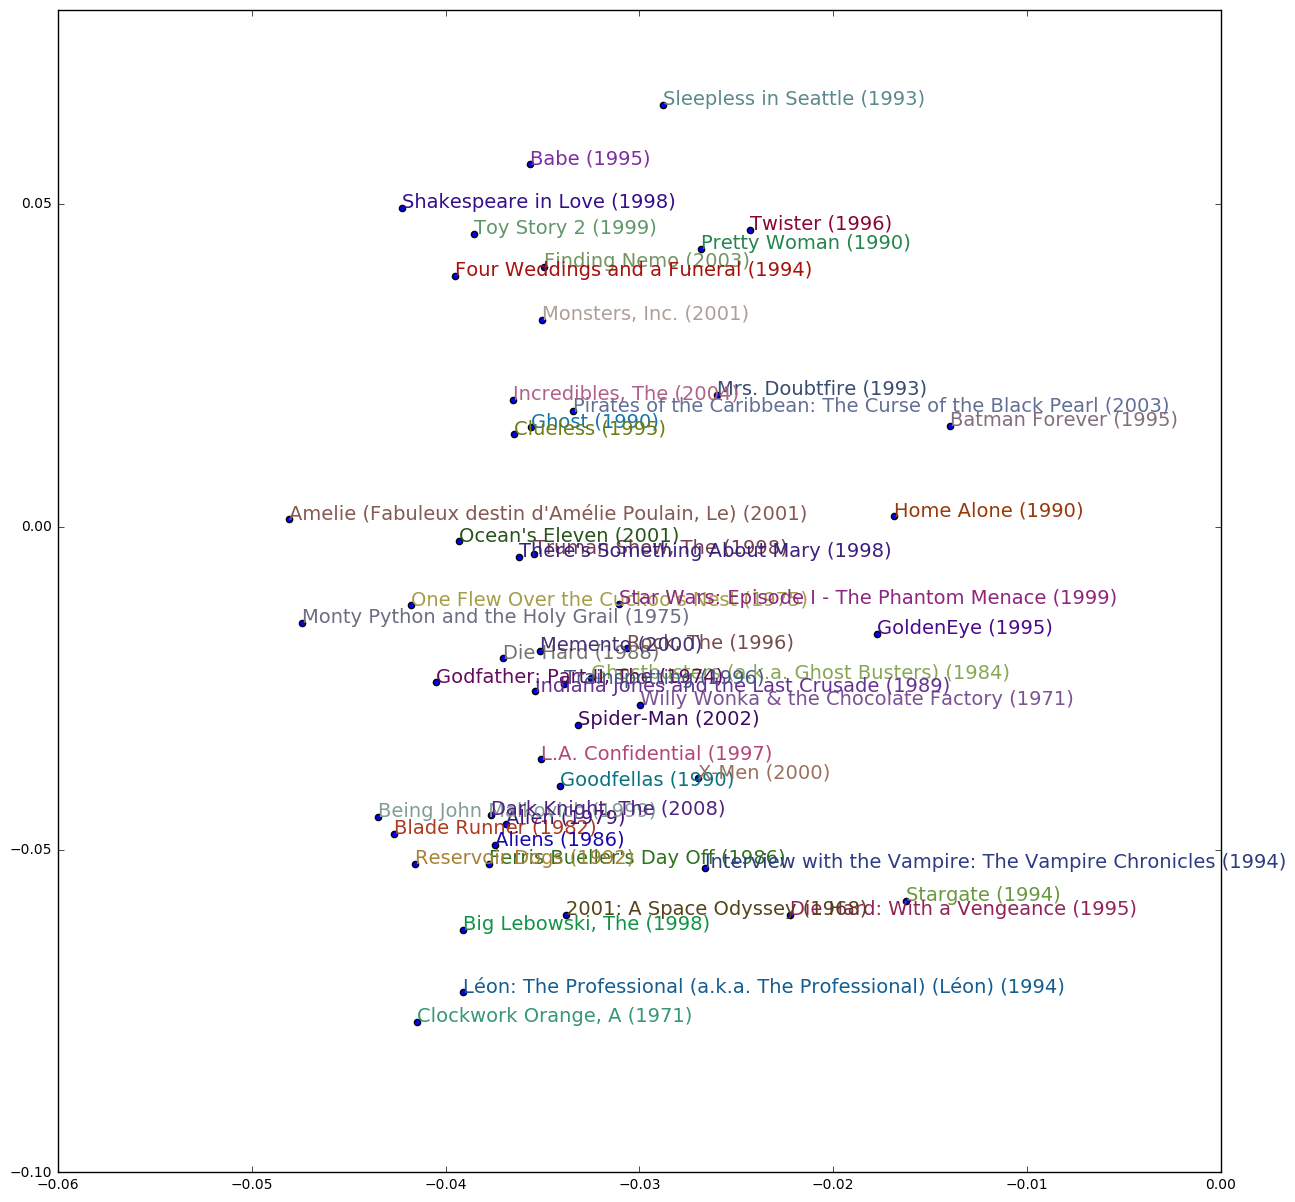

In [61]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [62]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [63]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [64]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79861 samples, validate on 20143 samples
Epoch 1/8
79861/79861 [==============================] - 7s - loss: 2.5790 - val_loss: 0.9282
Epoch 2/8
79861/79861 [==============================] - 7s - loss: 1.5285 - val_loss: 0.9038
Epoch 3/8
79861/79861 [==============================] - 7s - loss: 1.2517 - val_loss: 0.8770
Epoch 4/8
79861/79861 [==============================] - 7s - loss: 1.0468 - val_loss: 0.8638
Epoch 5/8
79861/79861 [==============================] - 7s - loss: 0.9115 - val_loss: 0.8374
Epoch 6/8
79861/79861 [==============================] - 7s - loss: 0.8446 - val_loss: 0.8391
Epoch 7/8
79861/79861 [==============================] - 7s - loss: 0.8197 - val_loss: 0.8371
Epoch 8/8
79861/79861 [==============================] - 7s - loss: 0.8065 - val_loss: 0.8333


This improves on our already impressive accuracy even further!